# Multiple comparisons of treatment means

## 1. Introduction

Data from many experiments are analyzed using analysis of variance. If results indicate a statistical difference between treatment means, the next step is to identify where the differences lie. The ideal situation is to decide what comparisons will be made during experimental design. The comparisons should be independant, no more than the treatment degrees of freedom and have a concrete meaning in terms of experiment structure. If other comparisons are found to be significant, they should ideally be investigated in a further experiment.

## 2. Treatments with no structure

If there is no structure in the experiment, it is tempting to to perform pairwise comparisons of all treatment means.  The number of comparisons for $t$ treatment levels is $t(t-1)/2$. If there are 10 treatment levels, 45 comparisons will be made. If two random treatment levels are chosen and their means differ by more than the 5% LSD, we reject the hypothesis that the means are the same with a type I error of 5%. If the difference between the two means is smaller than the 5% LSD while in fact the treatments are different, we fail to reject the null hypothesis when it is false and commit a type II error. If we reduce the type I error by using the 1% LSD, we automatically increase the type II error. The probability of the type II error is $\beta$. $\beta - 1$ is the power of the test, the probability to reject the null hypothesis when it is false. The power of the test can be increased without increasing the type I error by increasing the number of replication. It is acceptable to use the LSD test for comparisons planned in advance, but not to do comparisons suggested by the data. For example, if the LSD test is used to compare the highest and the lowest means, the type I error is higher than 5%.

We will identify 5% of all our comparisons as significantly different will there is no difference, this is the **comparison-wise error rate**. The **experiment-wise error rate** is the probability of dectecting at least one significant difference in our experiment and is calculated as $1 - (1 - 0.05)^c$ where c is the number of comparisons that are performed.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from itertools import repeat
from scipy.stats import f
from scipy.stats import t
from statsmodels.stats.libqsturng import qsturng #Q values of studentised range
from statsmodels.stats.libqsturng import psturng #p-values of studentised range

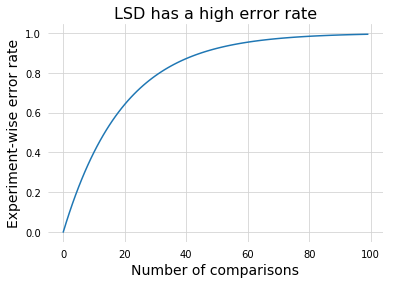

In [2]:
#plot of the experiment-wise error rate depending on the number of comparisons performed

#number of comparisons
c = np.array(list(range(100)))

#experiment-wise error rate
ewer = 1 - (1 - 0.05) ** c

#plot
fig, ax = plt.subplots()
ax.plot(c, ewer)
ax.set_xlabel('Number of comparisons', fontsize=14)
ax.set_ylabel('Experiment-wise error rate', fontsize=14)
ax.set_title('LSD has a high error rate', fontsize=16)
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(color='lightgrey')
ax.tick_params(axis='both', color='white')
plt.show()

The problem with the LSD test is the high experiment-wise error rate. Other tests have been developed to control this. They are not as powerful as the LSD test, as they do not detect as many differences that are real. We will present the LSD test as a reference, then the other tests. 

In our example, six varieties are replicated four times using a randomised block design.

In [4]:
varieties = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']

#number of replication per variety
n = 4

#residual degrees of freedom
resid_df = 15

#variety means
means = np.array([50.8, 69.2, 25, 89, 76.2, 74])
means_tup = [('V1', 50.8), ('V2', 69.2), ('V3', 25), ('V4', 89), ('V5', 76.2), ('V6', 74)]

#residual mean square
resid_ms = 144.45

#standard error of difference between two means
sed = np.sqrt(2 * resid_ms / n)

### 2.1 Least significant difference

The least significant difference at the 5% level is: 
$$LSD \thinspace(5\%)=t_{(15,\thinspace 2.5\%)} \times SED$$

Some protection against making a high type I error is afforded by user the **Fisher's protected LSD** procedure. This is the same as the ordinary LSD test but no comparisons are made if the F-test used to test the null hypothesis of equal treatment effects shows a non-significant result.

In [5]:
#dataframe of differences of means
diff = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#dataframe of p-values from LSD test of differences of means
p_lsd = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#loop over means to calculate difference and perform LSD test
for i in range(len(means) - 1):
    for j in range(i, len(means) - 1):
        difference = means[j + 1] - means[i]
        diff.iloc[i, j] = difference
        p_lsd.iloc[i, j] = 1 - t.cdf(abs(difference) / sed, resid_df)
        
print('Differences of means')
print(diff, '\n\n')
print('p-values (LSD test)')
print(p_lsd, '\n\n')

Differences of means
      V2    V3    V4    V5    V6
V1  18.4 -25.8  38.2  25.4  23.2
V2   NaN -44.2  19.8     7   4.8
V3   NaN   NaN    64  51.2    49
V4   NaN   NaN   NaN -12.8   -15
V5   NaN   NaN   NaN   NaN  -2.2 


p-values (LSD test)
           V2           V3           V4           V5           V6
V1  0.0234566   0.00417061  0.000213813   0.00459028   0.00775028
V2        NaN  5.37841e-05    0.0170962     0.211515     0.290278
V3        NaN          NaN  8.99106e-07  1.16357e-05  1.86416e-05
V4        NaN          NaN          NaN    0.0763988    0.0489532
V5        NaN          NaN          NaN          NaN     0.399628 




### 2.2 Tukey's Honestly Significant Difference (HSD) test

In the LSD test, the experiment-wise error rate increases as the number of treatments increases. The HSD test controls the experiment-wise error rate. For any given level of significance, a minimum significant difference(MSD) is calculated using the studentised range distribution. It is greater than the corresponding LSD. Whereas the LSD does not depend on the number of treatments, MSD increases with the number of treatments. 

$$MSD = Q \times \sqrt{\frac{RMS}{r}} = 4.595 \times \sqrt{\frac{144.54}{4}} = 27.62$$

To calculate Studentised range Q and p values we use `qsturng` and `psturng` function from `statsmodels.stats.libqsturng` with n = 6 (the number of means we compare) and df = 15 (the residual degrees of freedom).

In [6]:
#dataframe of p-values from HSD test of differences of means
p_hsd = pd.DataFrame(index=varieties[:-1], columns=varieties[1:])

#loop over means to perform an HSD test
for i in range(len(means) - 1):
    for j in range(i, len(means) - 1):
        q = abs(means[j + 1] - means[i]) / np.sqrt(resid_ms / 4)
        p_hsd.iloc[i, j] = psturng(q, 6, 15)
        
print('Differences of means')
print(diff, '\n\n')
print('p-values (HSD test)')
print(p_hsd, '\n\n')

Differences of means
      V2    V3    V4    V5    V6
V1  18.4 -25.8  38.2  25.4  23.2
V2   NaN -44.2  19.8     7   4.8
V3   NaN   NaN    64  51.2    49
V4   NaN   NaN   NaN -12.8   -15
V5   NaN   NaN   NaN   NaN  -2.2 


p-values (HSD test)
          V2          V3          V4         V5        V6
V1  0.308349   0.0739432  0.00468076  0.0804718  0.126227
V2       NaN  0.00123635    0.241727        0.9       0.9
V3       NaN         NaN       0.001      0.001     0.001
V4       NaN         NaN         NaN   0.649066  0.512556
V5       NaN         NaN         NaN        NaN       0.9 




### 2.3 Student-Newman-Keuls (SNK) test

This is a multiple-range test intermediate in power between the LSD and the HSD tests. For comparing the largest versus the smallest mean it is equivalent to Tukey's test. For comparing means of adjacent magnitude it is equivalent to the LSD test. Let's go through the SNK procedure step by step. More declarations of significance are made with this test than using Tukey's test, but fewer than with the LSD test.

In [7]:
#arrange t means in order of magnitude
means_sort = np.argsort(means)

#calculate MSD t - 1 times for t, t - 1, ... 2 means
snk = []
for treat in range(len(means), 1, -1):
    snk.append(qsturng(0.95, treat, resid_df) * np.sqrt(resid_ms / 4))
#snk = snk[::-1]

print('Original mean order: ', means_tup)
print('Sorted means: ', sorted(means))
print('SNK values: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}\n\n'.format(*snk))
    
#compare the highest and lowest means using SNK(t)
print('=== Comparison of SNK values to differences of means ===\n')
print('SNK(6): {:.2f}'.format(snk[0]))
print('Difference of highest and lowest mean : {:.2f}'.format(sorted(means)[5] - sorted(means)[0]))
print('V3 and V4 are significantly different\n')

#compare the two ranges of t - 1 adjacent ranked means with SNK(t - 1)
print('SNK(5): {:.2f}'.format(snk[1]))
print('Differences of (t - 1) range means: {:.2f} and {:.2f}'.format(sorted(means)[4] - sorted(means)[0],
                                                                     sorted(means)[5] - sorted(means)[1]))
print('V3 and V5 are significantly different, V1 and V4 are significantly different\n')

#compare the two ranges of t - 2 adjacent ranked means with SNK(t - 2)
print('SNK(4): {:.2f}'.format(snk[2]))
print('Differences of (t - 2) range means: {:.2f} and {:.2f}'.format(sorted(means)[3] - sorted(means)[0],
                                                                     sorted(means)[5] - sorted(means)[2]))
print('V3 and V6 are significantly different, but V2 and V4 are not significantly different\n')

#compare one range of t - 3 ranked means with SNK(t - 3)
#we do not compare means between V2 and V4 as their difference is not significant
print('SNK(3): {:.2f}'.format(snk[3]))
print('Differences of (t - 3) range means: {:.2f}'.format(sorted(means)[2] - sorted(means)[0]))
print('V3 and V2 are significantly different\n')

#compare one range of t - 4 ranked means with SNK(t - 4)
print('SNK(2): {:.2f}'.format(snk[4]))
print('Differences of (t - 4) range means: {:.2f}'.format(sorted(means)[1] - sorted(means)[0]))
print('V3 and V1 are significantly different\n')

Original mean order:  [('V1', 50.8), ('V2', 69.2), ('V3', 25), ('V4', 89), ('V5', 76.2), ('V6', 74)]
Sorted means:  [25.0, 50.8, 69.2, 74.0, 76.2, 89.0]
SNK values: 27.61, 26.25, 24.50, 22.07, 18.11


=== Comparison of SNK values to differences of means ===

SNK(6): 27.61
Difference of highest and lowest mean : 64.00
V3 and V4 are significantly different

SNK(5): 26.25
Differences of (t - 1) range means: 51.20 and 38.20
V3 and V5 are significantly different, V1 and V4 are significantly different

SNK(4): 24.50
Differences of (t - 2) range means: 49.00 and 19.80
V3 and V6 are significantly different, but V2 and V4 are not significantly different

SNK(3): 22.07
Differences of (t - 3) range means: 44.20
V3 and V2 are significantly different

SNK(2): 18.11
Differences of (t - 4) range means: 25.80
V3 and V1 are significantly different



### 2.4 Duncan's multiple range test (DMRT)

This test was once very popular but now most statisticians warn against its use because it does not control the type I experiment-wise error sufficiently. It is very similar to the SNK test except the critical ranges are smaller. These ranges are calculated by the same formula as for the SNK test but a special table is used instead of the Studentised range table. It is more powerful than the SNK test but also has a higher type I error.

### 2.5 Waller-Duncan's Bayes MSD test

In this test, all possible pairs of means are compared by calculating a minimum significant difference (MSD) whose value depends on the result of the F-test in the ANOVA. The higher the variance ratio (VR), the smaller the critical MSD, thereby increasing the power of the test. If the VR is small (indicating little overall difference), the MSD is increased, making it less likely that two means will be declared significant. The advantage of this test is that it is almost as powerful as the ordinary LSD but does not suffer from having a high type I experiment-wise error.

### 2.6 Summary of multiple-comparison tests

The number of significant differences between two means were as follows: LSD(10), Tukey(5), SNK(9), DMR(10), WDB(10). There is no consensur on which test is best, it is a tradeoff between making a type I and a type II error.

### 2.7 Least significant increase (LSI)

In many experiments, treatments are compared with a standard. In a plant breeding trial, we would look for new variety which give higher yield or quality than the standards. For this purpose, we can use the LSI procedure which is the one-sided version of LSD. It consists of a series of one-tailed t-tests. If each variety is equally replicated, a single LSD value can be used and the formula for the tests at the 5% level is:

$$LSI = t_{(Rdf, \thinspace 5\%)} \times \sqrt{\frac{2 \times RMS}{r}} = t_{(Rdf, \thinspace 5\%)} \times SED$$

where $Rdf$ is the residual degrees of freedom and RMS is the residual mean square from the ANOVA table. Let's compare the means of our previous example.

In [19]:
#calculate the least significant increase
lsi = t.ppf(0.95, resid_df) * sed

#determine if test varieties outyield the standard V1
print("Least Significant Increase at 5% level.\n'True' if variety outyields V1, 'False' otherwise.")
diff.loc['V1'] >= lsi

Least Significant Increase at 5% level.
'True' if variety outyields V1, 'False' otherwise.


V2     True
V3    False
V4     True
V5     True
V6     True
Name: V1, dtype: bool

### 2.8 One-sided confidence intervals

Confidence intervals give more information than significance tests. We calculate the confidence interval for the increase in mean yields compared to the standard variety and subtract LSI. We are then 95% confident that a variety outyields V1 by their difference in means minus LSI.

In [24]:
#calculate one-sided confidence intervals
print("One-sided confidence interval.\nWe are 95% confident the varieties outyield V1 by the following values.")

#we filter the results to remove varieties with lower yield
(diff.loc['V1'] - lsi)[diff.loc['V1'] >= lsi]

One-sided confidence interval.
We are 95% confident the varieties outyield V1 by the following values.


V2    3.50165
V4    23.3017
V5    10.5017
V6    8.30165
Name: V1, dtype: object

## 3. Treatments with structure (factorial structure)